# Grayscale Image Segmentation And Validation

In [ ]:
This notebook 

In [1]:
import matplotlib.pyplot as plt

import cv2
import natsort
import numpy as np
import os
import glob
import pandas as pd
import sys
import trackpy as tp
import scipy.misc
import scipy.ndimage
import sklearn.metrics

plt.ion()

1. Martin Maška, Vladimír Ulman, David Svoboda, Pavel Matula, Petr Matula, Cristina Ederra, Ainhoa Urbiola, Tomás España, Subramanian Venkatesan, Deepak M.W. Balak, Pavel Karas, Tereza Bolcková, Markéta Štreitová, Craig Carthel, Stefano Coraluppi, Nathalie Harder, Karl Rohr, Klas E. G. Magnusson, Joakim Jaldén, Helen M. Blau, Oleh Dzyubachyk, Pavel Křížek, Guy M. Hagen, David Pastor-Escuredo, Daniel Jimenez-Carretero, Maria J. Ledesma-Carbayo, Arrate Muñoz-Barrutia, Erik Meijering, Michal Kozubek, Carlos Ortiz-de-Solorzano; A benchmark for comparison of cell tracking algorithms, Bioinformatics, Volume 30, Issue 11, 1 June 2014, Pages 1609–1617, https://doi.org/10.1093/bioinformatics/btu080
2. Ulman, Vladimír & Maška, Martin & E G Magnusson, Klas & Ronneberger, Olaf & Haubold, Carsten & Harder, Nathalie & Matula, Pavel & Matula, Petr & Svoboda, David & Radojevic, Miroslav & Smal, Ihor & Rohr, Karl & Jaldén, Joakim & Blau, Helen & Dzyubachyk, Oleh & Lelieveldt, Boudewijn & Xiao, Pengdong & Li, Yuexiang & Cho, Siu-Yeung & Ortiz-de-Solorzano, Carlos. (2017). An Objective Comparison of Cell Tracking Algorithms. Nature Methods. 14. 10.1038/nmeth.4473. 


In [3]:
DATA_DIR = os.path.join(os.getcwd(), "data")
GRAYSCALE_DIR = os.path.join(DATA_DIR,"grayscale") + os.sep
GROUNDTRUTH_SEGMENTED_DIR = os.path.join(DATA_DIR, "groundtruth_segmentation") + os.sep
GROUNDTRUTH_TRACKING_DIR = os.path.join(DATA_DIR, "groundtruth_tracking") + os.sep
LI_THRESHOLDED_DIR = os.path.join(DATA_DIR, "li_thresholded") + os.sep
YEN_THRESHOLDED_DIR = os.path.join(DATA_DIR, "yen_thresholded") + os.sep
OTSU_THRESHOLDED_DIR = os.path.join(DATA_DIR, "otsu_thresholded") + os.sep
CONFUSION_MATRIX_MASK_DIR = os.path.join(DATA_DIR, "confusion_matrix") + os.sep

GRAYSCALE_IMAGES = natsort.natsorted(glob.glob(GRAYSCALE_DIR + "*.tif"))
GROUNDTRUTH_SEGMENTED_IMAGES = natsort.natsorted(glob.glob(GROUNDTRUTH_SEGMENTED_DIR + "*.tif"))
GROUNDTRUTH_TRACKING_IMAGES = natsort.natsorted(glob.glob(GROUNDTRUTH_TRACKING_DIR + "*.tif"))

print("number of grayscale images are {}".format(len(GRAYSCALE_IMAGES)))
print("number of images manually segmented are {}".format(len(GROUNDTRUTH_SEGMENTED_IMAGES)))
print("number of images manually tracked are {}".format(len(GROUNDTRUTH_TRACKING_IMAGES)))
      
# Not all images are manually segmented, collect the subset of grayscale images that are manually segmented
data_files = []
for data in GRAYSCALE_IMAGES:
    for groundtruth in GROUNDTRUTH_SEGMENTED_IMAGES:
        if os.path.basename(groundtruth) == os.path.basename(data):
            data_files.append(data)

print("obtained {} number of grayscale images that are manually segmented".format(len(data_files)))

# To generate a video/gif from images in a folder/directory using ffmpeg run
# ffmpeg -framerate 5 -pattern_type glob -i '*.png' -c:v libx264 -pix_fmt yuv420p out.mp4

number of grayscale images are 48
number of images manually segmented are 18
number of images manually tracked are 48
obtained 18 number of grayscale images that are manually segmented


SCALING TO UINT8

In [4]:
def convert_to_uint8(image):
    pmin, pmax = np.percentile(image, (0, 100))
    clipped_image = np.clip(image, pmin, pmax)
    clipped_image = (clipped_image - pmin) / (pmax - pmin)
    clipped_image = (255 * clipped_image).astype(np.uint8)
    return clipped_image

# SEGMENTATION/THRESHOLDING USING SKIMAGE 

/home/pranathi/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_yen
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum


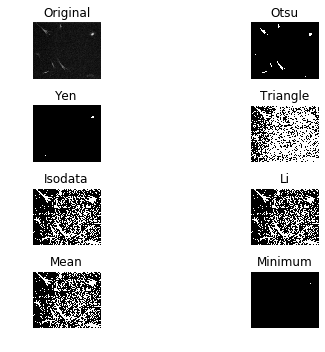

In [125]:
image = convert_to_uint8(scipy.misc.imread(data_files[0]))
image = scipy.ndimage.median_filter(image)
result = skimage.filters.thresholding.try_all_threshold(image)

1. Otsu threshold - The algorithm assumes that the image contains two classes of pixels following bi-modal histogram (foreground pixels and background pixels), it then calculates the optimum threshold separating the two classes so that their combined spread (intra-class variance) is minimal, or equivalently (because the sum of pairwise squared distances is constant), so that their inter-class variance is maximal

In [5]:
def segment_im(im, method):
    """
    Return a binary image with 0's and 255's after using threshold calculated by using the given "method"
    """
    return np.uint8(im > method(im)) * 255

# Validation metrics

Takeaway - Matthew Correlation Coefficient -https://lettier.github.io/posts/2016-08-05-matthews-correlation-coefficient.html

In [15]:
def get_validation_metrics(groundtruth, predicted):
    """
    Return validation metrics dictionary with accuracy, f1 score, mcc after
    comparing ground truth and predicted image

    :param groundtruth list of ground truth labels with binary values
    :param predicted list of predicted labels with binary values
    :return returns a dictionary with accuracy,f1 score, tp, tn, fp, fn, and mcc as keys
    """
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(groundtruth, predicted).ravel()
    validation_metrics = {}

    validation_metrics["tp"] = tp
    validation_metrics["fp"] = fp
    validation_metrics["fn"] = fn
    validation_metrics["tn"] = tn
    total = tp + fp + fn + tn
    accuracy = (tp + tn) / total
    validation_metrics["accuracy"] = accuracy
    # If all elements are non zero class
    if np.unique(groundtruth).tolist() == np.unique(predicted).tolist() == [1]:
        tn, fp, fn, tp = 0, 0, 0, len(groundtruth)
        f1_score = 1
    # if all elements are zero class i.e background
    elif np.unique(groundtruth).tolist() == np.unique(predicted).tolist() == [0]:
        tn, fp, fn, tp = len(groundtruth), 0, 0, 0
        f1_score = 1
    else:
        tn, fp, fn, tp = sklearn.metrics.confusion_matrix(groundtruth, predicted).ravel()
        f1_score = 2 * tp / ((2 * tp) + fp + fn)
    
    validation_metrics["f1_score"] = f1_score
    
    tn = np.float64(tn)
    fp = np.float64(fp)
    fn = np.float64(fn)
    tp = np.float64(tp)
    
    # edge cases
    if (tp == 0 and fp == 0):
        mcc = 0
    elif (tn == 0 and fn == 0):
        mcc = 0
    elif (fp == 0 and fn == 0):
        mcc = 1
    elif (tp == 0 and tn == 0):
        mcc = -1
    elif (tp == 0 and fn == 0):
        mcc = 0
    elif (tn == 0 and fp == 0):
        mcc = 0
    else:
        mcc = ((tp * tn) - (fp * fn)) / (np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)))
           
    validation_metrics["mcc"] = mcc
    return validation_metrics

Get validation metrics comparing 1.li and ground truth 2. otsu threshold  and ground truth 

In [ ]:
grayscale = imread(image)
plt.imsshow(grayscale, cmap='gray')

In [ ]:
median_filtered = scipy.ndimage.median_filtered(grayscale)
plt.imshow(median_filtered, cmap='gray')

In [ ]:
predicted = segment_im(median_filtered, skimage.filters.threshold_otsu)
plt.imshow(predicted, cmap='gray')

In [ ]:
validation_metrics = get_validation_metrics(groundtruth, predicted)
print(validation_metrics)